In [1]:
import glob
import matplotlib.pyplot as plt
import cv2
import os
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.utils import make_grid
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split

import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataset_path = "/content/drive/MyDrive/sem3/BioMedical Data Analysis/ocelot2023_v0.1.2"

## Pre-processing

In [3]:
image_folder = dataset_path + "/images/train/tissue"
mask_folder = dataset_path + "/annotations/train/tissue"

In [4]:

# Get the list of image and mask files
image_files = sorted(os.listdir(image_folder))
mask_files = sorted(os.listdir(mask_folder))

images = []
masks  = []

# Load and normalize images
for filename in image_files[:100]:
    img_path = os.path.join(image_folder, filename)
    img = cv2.imread(img_path)
    img = img.astype('float32') / 255.0  # Normalize to [0, 1]
    images.append(img)

# Load and normalize masks
for filename in mask_files[:100]:
    mask_path = os.path.join(mask_folder, filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    mask[mask == 255] = 0
    mask[mask == 1] = 0
    mask[mask == 2] = 255 # tumor
    mask = mask.astype('float32') / 255.0  # Normalize to [0, 1]
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)


In [5]:
images[10].shape, masks[10].shape

((1024, 1024, 3), (1024, 1024))

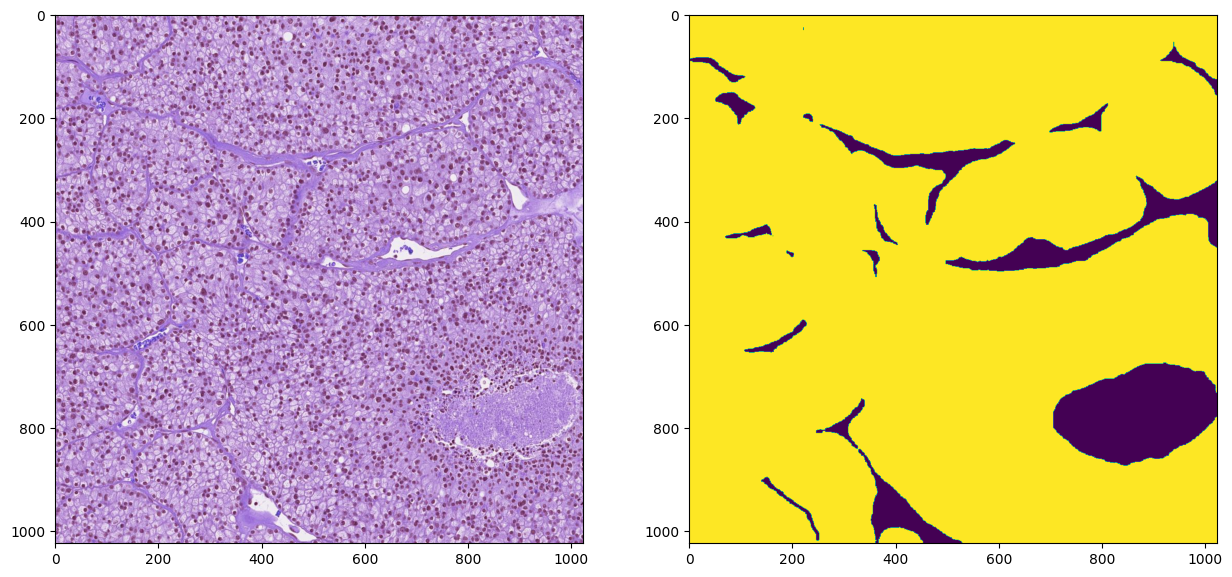

In [6]:
fig,ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(images[5])
ax[1].imshow(masks[5])


creating dataloaders

In [7]:
from torch.utils.data import Dataset
import torch
import numpy as np

class CloudSegmentationDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].transpose((2, 0, 1))  # Change to channel-first
        label = self.labels[idx][np.newaxis, :, :]     # Add channel dimension
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float)

In [8]:
from torch.utils.data import DataLoader, random_split

# Assuming true_patches and label_patches are your lists of images and labels
dataset = CloudSegmentationDataset(images=images, labels=masks)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False) # No need to shuffle the validation set

In [9]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

## Models

In [10]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [11]:
def get_jaccard_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    jaccard = np.sum(intersection) / np.sum(union)
    return jaccard

def get_dice_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    dice = 2 * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice

from sklearn.metrics import accuracy_score

# Function to threshold the predictions
def threshold_predictions(predictions, threshold=0.5):
    return (predictions > threshold).astype(np.uint8)

### Model 1: SnE-Unet

In [16]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [20]:

class SEUNetLightning(pl.LightningModule):
    def __init__(self):
        super(SEUNetLightning, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Max-pooling layer
        self.pool = nn.MaxPool2d(2)

        # Upsampling layer
        self.up = nn.ModuleList([
            nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),
        ])

        # Decoder
        self.up3 = self.up_conv_block(512+256, 256)
        self.up2 = self.up_conv_block(256+128, 128)
        self.up1 = self.up_conv_block(128+64, 64)

        # Final Output Layer
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)
        )

    def up_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Upsampling enc4 to match enc3
        up_enc4 = self.up[0](enc4)
        up3 = self.up3(torch.cat((enc3, up_enc4), 1))

        # Upsampling up3 to match enc2
        up3_upsampled = self.up[1](up3)
        up2 = self.up2(torch.cat((enc2, up3_upsampled), 1))

        # Upsampling up2 to match enc1
        up2_upsampled = self.up[2](up2)
        up1 = self.up1(torch.cat((enc1, up2_upsampled), 1))

        # Final Output
        out = self.final_conv(up1)
        return self.sigmoid(out)

    def training_step(self, batch, batch_idx):
        data, target = batch
        outputs = self.forward(data)
        loss = nn.BCELoss()(outputs, target)
        self.log('train_loss', loss, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        outputs = self.forward(data)
        loss = nn.BCELoss()(outputs, target)
        self.log('val_loss', loss, on_epoch=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer


In [19]:
logger = TensorBoardLogger('lightning_logs/', name='SEUnet-Segment')
# Model checkpoint callback
checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      mode='min',
                                      save_top_k=1,
                                      verbose=True,
                                      save_last=True,
                                      dirpath='model_checkpoints/',
                                      filename='best-checkpoint')


trainer = Trainer(max_epochs=5,
                  log_every_n_steps=13,
                  logger=logger,
                  accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                  callbacks=[checkpoint_callback])


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [20]:
model1 = SEUNetLightning()

In [22]:
trainer.fit(model1, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/model_checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name       | Type       | Params
-------------------------------------------
0  | enc1       | Sequential | 39.8 K
1  | enc2       | Sequential | 225 K 
2  | enc3       | Sequential | 901 K 
3  | enc4       | Sequential | 3.6 M 
4  | pool       | MaxPool2d  | 0     
5  | up         | ModuleList | 1.4 M 
6  | up3        | Sequential | 2.4 M 
7  | up2        | Sequential | 590 K 
8  | up1        | Sequential | 147 K 
9  | final_conv | Conv2d     | 65    
10 | sigmoid    | Sigmoid    | 0     
-------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params
36.993    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 218: 'val_loss' reached 0.65132 (best 0.65132), saving model to '/content/model_checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 298: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 378: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 458: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [23]:
from torch import optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
device

device(type='cuda')

In [24]:
# Initialize metrics
total_accuracy = 0
total_jaccard = 0
total_dice = 0

# Switch to evaluation mode
model1.eval()

# Iterate through the validation loader
with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        model1.to(device)
        # Forward pass
        outputs = model1(data)

        # Convert to numpy
        y_true = target.cpu().numpy()
        y_pred = outputs.cpu().numpy()

        # Threshold predictions
        y_pred = threshold_predictions(y_pred)

        # Calculate metrics for this batch
        batch_accuracy = accuracy_score(y_true.ravel(), y_pred.ravel())
        batch_jaccard = get_jaccard_score(y_true, y_pred)
        batch_dice = get_dice_score(y_true, y_pred)

        # Accumulate metrics
        total_accuracy += batch_accuracy
        total_jaccard += batch_jaccard
        total_dice += batch_dice

# Divide by the number of batches to get the mean metrics
mean_accuracy = total_accuracy / len(val_loader)
mean_jaccard = total_jaccard / len(val_loader)
mean_dice = total_dice / len(val_loader)

print('Validation Accuracy:', mean_accuracy)
print('Mean Jaccard Score:', mean_jaccard)
print('Mean Dice Score:', mean_dice)


Validation Accuracy: 0.6141135692596436
Mean Jaccard Score: 0.6141128130310032
Mean Dice Score: 0.7316891056716037


### Model 2: Normal U-Net

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer

class UNetLightning(pl.LightningModule):
    def __init__(self):
        super(UNetLightning, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Max-pooling layer
        self.pool = nn.MaxPool2d(2)

        # Upsampling layer
        self.up = nn.ModuleList([
            nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),
        ])

        # Decoder
        self.up3 = self.up_conv_block(512+256, 256)
        self.up2 = self.up_conv_block(256+128, 128)
        self.up1 = self.up_conv_block(128+64, 64)

        # Final Output Layer
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Upsampling enc4 to match enc3
        up_enc4 = self.up[0](enc4)
        up3 = self.up3(torch.cat((enc3, up_enc4), 1))

        # Upsampling up3 to match enc2
        up3_upsampled = self.up[1](up3)
        up2 = self.up2(torch.cat((enc2, up3_upsampled), 1))

        # Upsampling up2 to match enc1
        up2_upsampled = self.up[2](up2)
        up1 = self.up1(torch.cat((enc1, up2_upsampled), 1))

        # Final Output
        out = self.final_conv(up1)
        return self.sigmoid(out)

    def training_step(self, batch, batch_idx):
        data, target = batch
        outputs = self.forward(data)
        loss = nn.BCELoss()(outputs, target)
        self.log('train_loss', loss, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        outputs = self.forward(data)
        loss = nn.BCELoss()(outputs, target)
        self.log('val_loss', loss, on_epoch=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer




In [12]:
logger = TensorBoardLogger('lightning_logs/', name='UNet-Segment')
# Model checkpoint callback
checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      mode='min',
                                      save_top_k=1,
                                      verbose=True,
                                      save_last=True,
                                      dirpath='model_checkpoints/',
                                      filename='best-checkpoint')


trainer = Trainer(max_epochs=5,
                  log_every_n_steps=13,
                  logger=logger,
                  accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                  callbacks=[checkpoint_callback])

model2 = UNetLightning()
trainer.fit(model2, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/model_checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name       | Type       | Params
-------------------------------------------
0  | enc1       | Sequential | 38.7 K
1  | enc2       | Sequential | 221 K 
2  | enc3       | Sequential | 885 K 
3  | enc4       | Sequential | 3.5 M 
4  | pool       | MaxPool2d  | 0     
5  | up         | ModuleList | 1.4 M 
6  | up3        | Sequential | 2.4 M 
7  | up2        | Sequential | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 80: 'val_loss' reached 0.68621 (best 0.68621), saving model to '/content/model_checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 160: 'val_loss' reached 0.66837 (best 0.66837), saving model to '/content/model_checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 240: 'val_loss' reached 0.64915 (best 0.64915), saving model to '/content/model_checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 320: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 400: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [14]:
from torch import optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
device

device(type='cuda')

In [18]:
# Initialize metrics
total_accuracy = 0
total_jaccard = 0
total_dice = 0

# Switch to evaluation mode
model2.eval()

# Iterate through the validation loader
with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        model2.to(device)
        # Forward pass
        outputs = model2(data)

        # Convert to numpy
        y_true = target.cpu().numpy()
        y_pred = outputs.cpu().numpy()

        # Threshold predictions
        y_pred = threshold_predictions(y_pred)

        # Calculate metrics for this batch
        batch_accuracy = accuracy_score(y_true.ravel(), y_pred.ravel())
        batch_jaccard = get_jaccard_score(y_true, y_pred)
        batch_dice = get_dice_score(y_true, y_pred)

        # Accumulate metrics
        total_accuracy += batch_accuracy
        total_jaccard += batch_jaccard
        total_dice += batch_dice

# Divide by the number of batches to get the mean metrics
mean_accuracy = total_accuracy / len(val_loader)
mean_jaccard = total_jaccard / len(val_loader)
mean_dice = total_dice / len(val_loader)

print('Validation Accuracy:', mean_accuracy)
print('Mean Jaccard Score:', mean_jaccard)
print('Mean Dice Score:', mean_dice)


Validation Accuracy: 0.5417471408843995
Mean Jaccard Score: 0.5417471408843995
Mean Dice Score: 0.636765724059394


### U-Net without skip connections

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer

class UNetLightning2(pl.LightningModule):
    def __init__(self):
        super(UNetLightning2, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Max-pooling layer
        self.pool = nn.MaxPool2d(2)

        # Upsampling layer
        self.up = nn.ModuleList([
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
        ])

        # Decoder
        self.up3 = self.up_conv_block(256, 256)
        self.up2 = self.up_conv_block(128, 128)
        self.up1 = self.up_conv_block(64, 64)

        # Final Output Layer
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Upsampling
        up_enc4 = self.up[0](enc4)
        up3 = self.up3(up_enc4)

        up3_upsampled = self.up[1](up3)
        up2 = self.up2(up3_upsampled)

        up2_upsampled = self.up[2](up2)
        up1 = self.up1(up2_upsampled)

        # Final Output
        out = self.final_conv(up1)
        return self.sigmoid(out)

    def training_step(self, batch, batch_idx):
        data, target = batch
        outputs = self.forward(data)
        loss = nn.BCELoss()(outputs, target)
        self.log('train_loss', loss, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        outputs = self.forward(data)
        loss = nn.BCELoss()(outputs, target)
        self.log('val_loss', loss, on_epoch=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer




In [13]:
logger = TensorBoardLogger('lightning_logs/', name='UNet-non-Segment')
# Model checkpoint callback
checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      mode='min',
                                      save_top_k=1,
                                      verbose=True,
                                      save_last=True,
                                      dirpath='model_checkpoints/',
                                      filename='best-checkpoint')


trainer = Trainer(max_epochs=5,
                  log_every_n_steps=13,
                  logger=logger,
                  accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                  callbacks=[checkpoint_callback])

model3 = UNetLightning2()
trainer.fit(model3, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/model_checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name       | Type       | Params
-------------------------------------------
0  | enc1       | Sequential | 38.7 K
1  | enc2       | Sequential | 221 K 
2  | enc3       | Sequential | 885 K 
3  | enc4       | Sequential | 3.5 M 
4  | pool       | MaxPool2d  | 0     
5  | up         | ModuleList | 688 K 
6  | up3        | Sequential | 1.2 M 
7  | up2        | Sequential | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 80: 'val_loss' reached 0.69494 (best 0.69494), saving model to '/content/model_checkpoints/best-checkpoint-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 160: 'val_loss' reached 0.68335 (best 0.68335), saving model to '/content/model_checkpoints/best-checkpoint-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 240: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 320: 'val_loss' reached 0.68311 (best 0.68311), saving model to '/content/model_checkpoints/best-checkpoint-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 400: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [14]:
from torch import optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
device

device(type='cuda')

In [15]:
# Initialize metrics
total_accuracy = 0
total_jaccard = 0
total_dice = 0

# Switch to evaluation mode
model3.eval()

# Iterate through the validation loader
with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        model3.to(device)
        # Forward pass
        outputs = model3(data)

        # Convert to numpy
        y_true = target.cpu().numpy()
        y_pred = outputs.cpu().numpy()

        # Threshold predictions
        y_pred = threshold_predictions(y_pred)

        # Calculate metrics for this batch
        batch_accuracy = accuracy_score(y_true.ravel(), y_pred.ravel())
        batch_jaccard = get_jaccard_score(y_true, y_pred)
        batch_dice = get_dice_score(y_true, y_pred)

        # Accumulate metrics
        total_accuracy += batch_accuracy
        total_jaccard += batch_jaccard
        total_dice += batch_dice

# Divide by the number of batches to get the mean metrics
mean_accuracy = total_accuracy / len(val_loader)
mean_jaccard = total_jaccard / len(val_loader)
mean_dice = total_dice / len(val_loader)

print('Validation Accuracy:', mean_accuracy)
print('Mean Jaccard Score:', mean_jaccard)
print('Mean Dice Score:', mean_dice)


Validation Accuracy: 0.6269335746765137
Mean Jaccard Score: 0.6269335746765137
Mean Dice Score: 0.7215335351582879


In [ ]:
from torch import optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
device

device(type='cuda')

In [26]:
model1 = SEUNetLightning.load_from_checkpoint('./model_checkpoints/best-checkpoint.ckpt').to(device)
model2 = UNetLightning.load_from_checkpoint('./model_checkpoints/best-checkpoint-v2.ckpt').to(device)
model3= UNetLightning2.load_from_checkpoint('./model_checkpoints/best-checkpoint-v5.ckpt').to(device)

In [22]:
import gc
torch.cuda.empty_cache()
gc.collect()

21

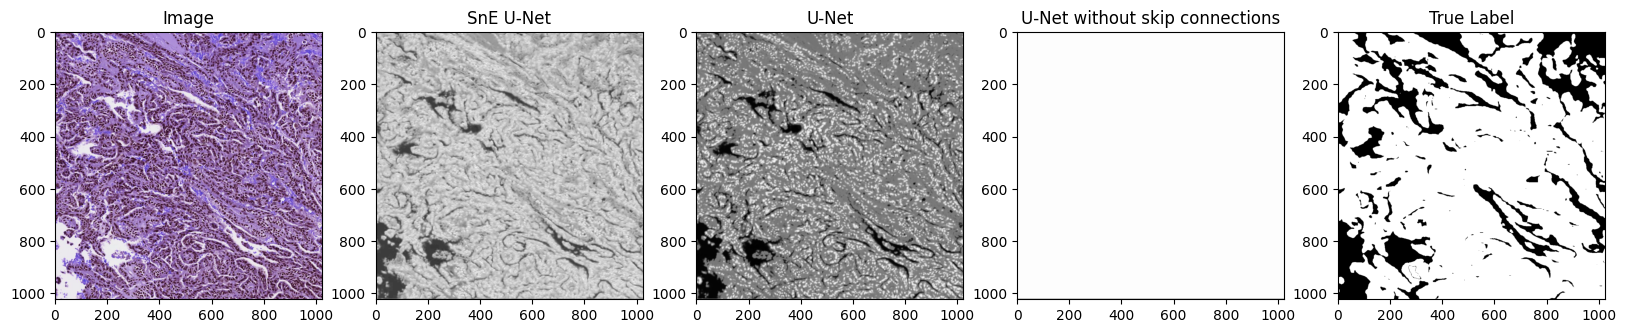

In [28]:
data_of_interest, target_of_interest = val_dataset[6]
data_of_interest = data_of_interest.unsqueeze(0).to(device)  # Adding batch dimension and moving to device
target_of_interest = target_of_interest.unsqueeze(0).to(device)  # Adding batch dimension and moving to device

with torch.no_grad():
    output1 = model1(data_of_interest)
    output2 = model2(data_of_interest)
    output3 = model3(data_of_interest)

fig, ax = plt.subplots(1, 5, figsize=(20, 20))
ax[0].imshow(np.transpose(data_of_interest.cpu().detach().numpy()[0,:,:,:], (1, 2, 0)))
ax[0].set_title("Image")
ax[1].imshow(output1.cpu().detach().numpy()[0,0,:,:],cmap = "gray")
ax[1].set_title("SnE U-Net")
ax[2].imshow(output2.cpu().detach().numpy()[0,0,:,:],cmap = "gray")
ax[2].set_title("U-Net")
ax[3].imshow(output3.cpu().detach().numpy()[0,0,:,:], cmap = "gray")
ax[3].set_title("U-Net without skip connections")
ax[4].imshow(target_of_interest.cpu().detach().numpy()[0,0,:,:],cmap = "gray")
ax[4].set_title("True Label")
plt.show()